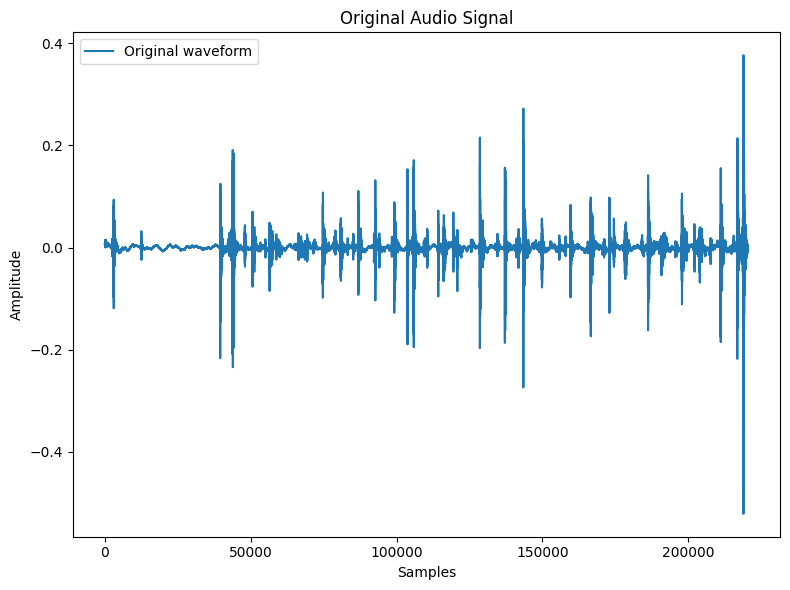

Processing with n_atoms = 256
Processing with n_atoms = 512
Processing with n_atoms = 1024
Processing with n_atoms = 2048


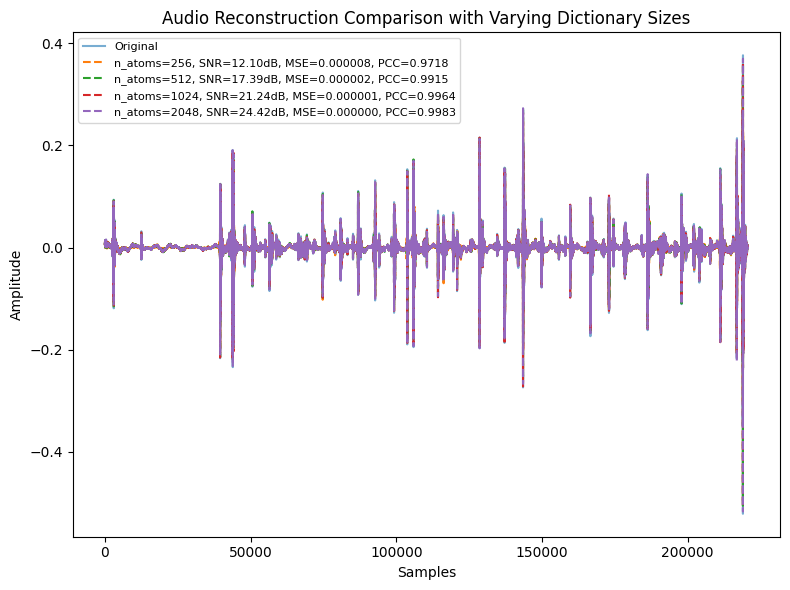

In [1]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.linear_model import OrthogonalMatchingPursuit
from scipy.signal import stft, istft, wiener
import soundfile as sf
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

# 1. Load File
audio_path = './1-137-A-32.wav'
y, sr = librosa.load(audio_path, sr=None)
plt.figure(figsize=(8, 6))
plt.plot(y, label="Original waveform")
plt.title("Original Audio Signal")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend()
plt.tight_layout()
plt.show()

# 2. STFT
f, t, Zxx = stft(y, fs=sr, nperseg=512)
Zxx_real = np.real(Zxx)

# 3. Evaluation metrics
def compute_metrics(original, reconstructed):
    min_len = min(len(original), len(reconstructed))
    original = original[:min_len]
    reconstructed = reconstructed[:min_len]
    noise = original - reconstructed
    snr = 10 * np.log10(np.sum(original**2) / np.sum(noise**2))
    mse = mean_squared_error(original, reconstructed)
    pcc, _ = pearsonr(original, reconstructed)
    return snr, mse, pcc

# 4. Loop over different n_atoms
n_atoms_list = [256, 512, 1024, 2048]
results = {}

for n_atoms in n_atoms_list:
    print(f"Processing with n_atoms = {n_atoms}")
    np.random.seed(42)  # Ensure reproducibility
    dictionary = np.random.randn(Zxx_real.shape[0], n_atoms)

    omp = OrthogonalMatchingPursuit(n_nonzero_coefs=100)
    sparse_coeffs = np.zeros((n_atoms, Zxx_real.shape[1]))

    for i in range(Zxx_real.shape[1]):
        omp.fit(dictionary, Zxx_real[:, i])
        sparse_coeffs[:, i] = omp.coef_

    Zxx_reconstructed = dictionary @ sparse_coeffs
    _, y_reconstructed = istft(Zxx_reconstructed + 1j * np.imag(Zxx), fs=sr, nperseg=512)
    y_reconstructed = wiener(y_reconstructed)

    snr, mse, pcc = compute_metrics(y, y_reconstructed)
    results[n_atoms] = {
        'signal': y_reconstructed,
        'snr': snr,
        'mse': mse,
        'pcc': pcc
    }

    # 保存音频文件
    sf.write(f'reconstructed_{n_atoms}_atoms.wav', y_reconstructed, sr)

# 5. Plot all results
plt.figure(figsize=(8, 6))
plt.plot(y, label="Original", alpha=0.6)

for n_atoms in n_atoms_list:
    y_recon = results[n_atoms]['signal']
    snr = results[n_atoms]['snr']
    mse = results[n_atoms]['mse']
    pcc = results[n_atoms]['pcc']
    plt.plot(y_recon, '--', label=f"n_atoms={n_atoms}, SNR={snr:.2f}dB, MSE={mse:.6f}, PCC={pcc:.4f}")

plt.title("Audio Reconstruction Comparison with Varying Dictionary Sizes")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()
